# Load libraries

In [1]:
# pip install tqdm networkx plotly matplotlib pandas jinja2 kaleido
# pip install --upgrade nbformat
import os
from tqdm import tqdm
from codes.bb import *
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Exploring data

In [2]:
# read nrm files
nmr_folder = 'data/nmr_spec'
df_nmr = {'fn': [], 'i': [], 'j': [], 'dij': []}
for fn in tqdm(os.listdir(nmr_folder)):
    if not fn.endswith('.nmr'):
        continue
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        for edge in fd:
            i, j, dij = edge.split()[:3]
            # parse the edge
            i, j, dij = int(i), int(j), float(dij)
            # add the edge
            df_nmr['fn'].append(fn)
            df_nmr['i'].append(i)
            df_nmr['j'].append(j)
            df_nmr['dij'].append(dij)
# convert to dataframe
df_nmr = pd.DataFrame(df_nmr)
# add columns for dmax, pdb and chain
df_nmr['DMAX'] = df_nmr['fn'].apply(lambda fn: int(fn.split('dmax_')[1].split('.')[0]))
df_nmr['PDB'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[0])
df_nmr['chain'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[2])

100%|██████████| 19/19 [00:00<00:00, 16898.17it/s]


In [3]:
def get_lenS(fnmr):
    flog = fnmr.replace('.nmr', '.log')
    with open(flog, 'r') as fd:
        for row in fd:
            if '> lenS' in row:
                return int(row.split()[-1])
# columns of interest
cols = ['PDB','DMAX','i','j','fn']
dfA = df_nmr[cols].groupby(['PDB','DMAX']).agg({'i':'count', 'j':'max', 'fn':'max'}).reset_index()
dfA.rename(columns={'i':'|E|', 'j':'|V|'}, inplace=True)
# dict of dataframes, one for each dmax
df_DMAX = {dmax:None for dmax in dfA['DMAX'].unique()} 
for dmax in df_DMAX:
    df_DMAX[dmax] = dfA[dfA['DMAX'] == dmax].groupby(['PDB','|V|']).max().reset_index()
    # rename columns
    df_DMAX[dmax].rename(columns={'|E|':f'|E_{dmax}|','fn':f'|S_{dmax}|'}, inplace=True)
    # parse the log file to get the length of S
    df_DMAX[dmax][f'|S_{dmax}|'] = df_DMAX[dmax][f'|S_{dmax}|'].apply(get_lenS)
    # drop redundant columns
    if dmax == min(df_DMAX):
        df_DMAX[dmax].drop(columns=['DMAX'], inplace=True)
    else:
        df_DMAX[dmax].drop(columns=['DMAX','|V|'], inplace=True)
# merge all dataframes
dfB = df_DMAX[min(df_DMAX)]
for dmax in df_DMAX:
    if dmax == min(df_DMAX):
        continue
    dfB = pd.merge(dfB, df_DMAX[dmax], on=['PDB'])
# sort by |V|
df_DMAX = dfB.sort_values(by=['|V|'])
cols = df_DMAX.columns.tolist()
# change df_MAX column order
cols = cols[:2] + sorted(cols[2:])
df_DMAX = df_DMAX[cols]
# convert to latex
tex = df_DMAX.to_latex(index=False,
                column_format='lrrc',
                header=cols, # list of column names
                escape=False,
                caption=f'Number of nodes and edges for each instance.',
                label=f'tab:instances',
                multicolumn=False,
                multicolumn_format='c')
# save tex to file
with open('latex/tables/instances.tex', 'w') as fd:
    fd.write(tex)
# display
df_DMAX

FileNotFoundError: [Errno 2] No such file or directory: 'data/nmr_spec/testA_chain_A_dmax_5.log'

In [131]:
# |s| is the number of edges covering the segment s
df = {'PDB':[], 'DMAX':[], 'sid':[], '|s|':[]}
for fn in tqdm(os.listdir(nmr_folder)):
    # skip non-dmp files
    if not fn.endswith('.dmp'):
        continue
    # get pdb and dmax
    pdb = fn.split('_')[0]
    dmax = int(fn.split('dmax_')[1].split('.')[0])
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        reading = False # flag to start reading
        for row in fd:
            if 'segments [sid i j weight EID]:' in row:
                reading = True
                continue
            if 'E [idx eid i j SID]:' in row:
                break
            if reading:
                v = [int(s) for s in row.split()]
                sid, i, j = int(v[0]), int(v[1]), int(v[2])                
                df['PDB'].append(pdb)
                df['DMAX'].append(dmax)
                df['|s|'].append(len(v)-4)
                df['sid'].append(sid)
df = pd.DataFrame(df)
dfA = df.groupby(['DMAX']).agg({'|s|':'max'}).reset_index().sort_values(by=['DMAX'])
dfA.rename(columns={'|s|':'|s|_max'}, inplace=True)
print(dfA)


100%|██████████| 147/147 [00:00<00:00, 32226.78it/s]

   DMAX  |s|_max
0     5        5


In [132]:
fig = go.Figure()
for dmax in df['DMAX'].unique():
    dfB = df[df['DMAX'] == dmax].sort_values(by=['|s|'])
    y, PDB, SID = dfB['|s|'], dfB['PDB'], dfB['sid']
    x = np.arange(1, len(y)+1) / len(y)    
    fig.add_trace(go.Scatter(x=x, y=y, name=f'dmax={dmax}'))
    # add pdb to the hover text
    fig.data[-1].text = [f'{pdb}, sid:{sid}' for pdb, sid in zip(PDB, SID)]
# Overlay both histograms
fig.update_layout(barmode='overlay')
# xlim
fig.update_xaxes(range=[0, 1.05])
# set title
fig.update_layout(title_text='CDF of number of edges per segment')
# set x-axis title
fig.update_xaxes(title_text='CDF')
# set y-axis title
fig.update_yaxes(title_text='Number of edges on a given segment', type="log")
fig.show()

# Exploring results:

## Results: data/nmr_spec

In [10]:
nmr_folder = 'data/nmr_rand'

# run read_results.py
os.system('python read_results.py -wdir ' + nmr_folder)

# read results
df = pd.read_csv(os.path.join(nmr_folder, 'results.csv'))
print('tmax (secs) =', df['tmax'].unique())
print('')

# add columns
df['PDB'] = df.apply(lambda row: row['fnmr'].split('/')[-1].split('_')[0], axis=1)

# set columns order
cols = ['PDB','|V|','|E|','|S|','costRX', 'costGD', 'costSB']
cols += sorted([c for c in df.columns if c not in cols])
df = df[cols]

# set columns names
cols = df.columns.tolist()
cols = {c:c.replace('cost', '') for c in cols}
df.rename(columns=cols, inplace=True)

# sort by |S|
df = df.sort_values(by=['|S|'])

# remove unnecessary columns
cols = ['fnmr', 'clean_log', 'verbose', 'dump', 'tmax']
cols += [c for c in df.columns if c.startswith('time')]
cols += [c for c in df.columns if c.startswith('cost')]
df.drop(columns=cols, inplace=True)

# display
caption = 'Table of costs for each instance.'
print(caption)
pd.set_option('display.float_format', lambda x: '%g' % x)
dfA = df.groupby('PDB').max().reset_index()

# remove col solver
dfA.drop(columns=['solver'], inplace=True)

# get results where the cost are different
dfA = dfA[dfA['GD'] != dfA['SB']]
dfA = dfA[dfA['GD'] != dfA['BB']]
dfA = dfA[dfA['SB'] != dfA['BB']]

# convert to latex
tex = dfA.to_latex(index=False,
                column_format='lrrrrrrrrr',
                header=dfA.columns, # list of column names
                escape=False,
                caption=caption,
                label=f'tab:costs',
                multicolumn=False,
                multicolumn_format='c')

# save tex to file
wdir = os.path.join('latex',nmr_folder)
if not os.path.exists(wdir):
    os.mkdir(wdir)
fn = os.path.join(wdir,'costs.tex')
# get full path
fn = os.path.abspath(fn)
print(f'Saving LaTeX table to "{fn}"')
with open(fn, 'w') as fd:
    fd.write(tex)

df = df[df['PDB'].isin(dfA['PDB'])]
df

Parameters:
   wdir = data/nmr_rand

Getting log files from wdir=data/nmr_rand
Saving results to data/nmr_rand/results.csv
tmax (secs) = [7200]

Table of costs for each instance.
Saving LaTeX table to "/mnt/michael/gitrepos/bb-sbbu/latex/data/nmr_rand/costs.tex"


,PDB,|V|,|E|,|S|,RX,GD,SB,BB,solver
15,test34,15,4,5,54,68,98,54,BB
12,test347,15,4,5,44,48,136,46,BB
19,test150,15,4,5,30,36,50,30,BB
6,test700,15,4,5,26,28,42,26,BB
18,test794,14,4,6,28,30,44,28,BB
20,test149,14,4,6,26,76,82,74,BB
13,test133,15,4,7,26,40,54,36,BB


In [11]:
dfA = {'PDB':[],'cost':[], 'algorithm':[]}
for i, row in df.iterrows():
    for c in df.columns:
        if c in ['PDB','|V|','|E|','|S|']:
            continue
        dfA['PDB'].append(row['PDB'])
        dfA['cost'].append(row[c])
        dfA['algorithm'].append(c)
dfA = pd.DataFrame(dfA)
# remove solver
dfA = dfA[dfA['algorithm']!='solver']
# remove nan
dfA = dfA[~dfA['cost'].isna()]
# remove duplicates
dfA = dfA.drop_duplicates(subset=['PDB','algorithm'])
# show
fig = px.bar(dfA, x='PDB', y='cost', color='algorithm', title='Costs per instance', barmode='group', log_y=True, text='cost')
# fig.update_yaxes(range=[1e-2, 1e4])
fig.update_traces(textposition='auto') # set text position
# change x-axis label
fig.update_xaxes(title_text='Instance ID')
# change legend title
fig.update_layout(legend_title_text='Algorithms')
fig.show()
# save fig to file
wdir = os.path.join('latex',nmr_folder)
if not os.path.exists(wdir):
    os.mkdir(wdir)
fig.write_image(os.path.join(wdir,'costs.pdf'))

raise Exception('stop')

Exception: stop

prune edges: [(1, 7), (4, 12), (7, 15), (9, 13)]
'/mnt/michael/gitrepos/bb-sbbu/data/nmr_rand/test133_chain_A_dmax_5.nmr'


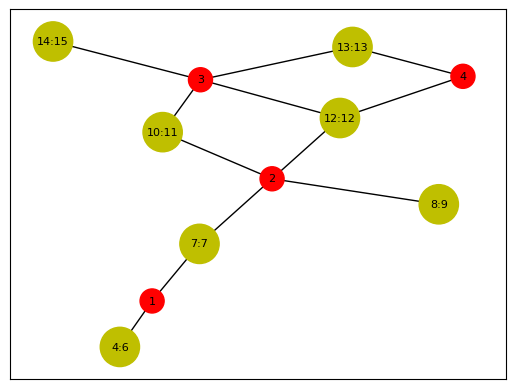

prune edges: [(1, 9), (3, 13), (4, 13), (10, 14)]
'/mnt/michael/gitrepos/bb-sbbu/data/nmr_rand/test149_chain_A_dmax_5.nmr'


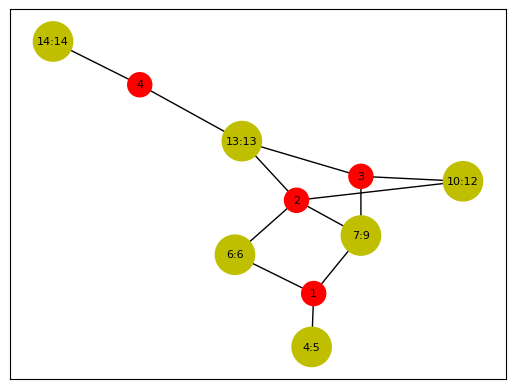

prune edges: [(3, 10), (4, 15), (7, 11), (8, 15)]
'/mnt/michael/gitrepos/bb-sbbu/data/nmr_rand/test150_chain_A_dmax_5.nmr'


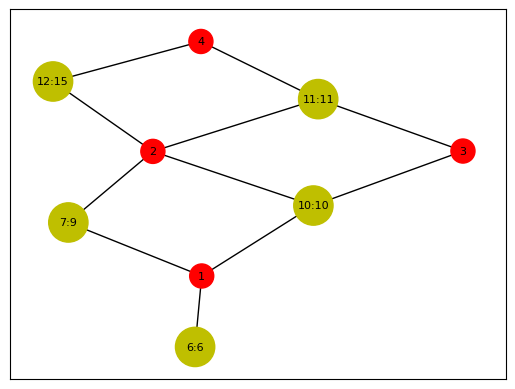

prune edges: [(2, 11), (2, 14), (7, 12), (9, 15)]
'/mnt/michael/gitrepos/bb-sbbu/data/nmr_rand/test347_chain_A_dmax_5.nmr'


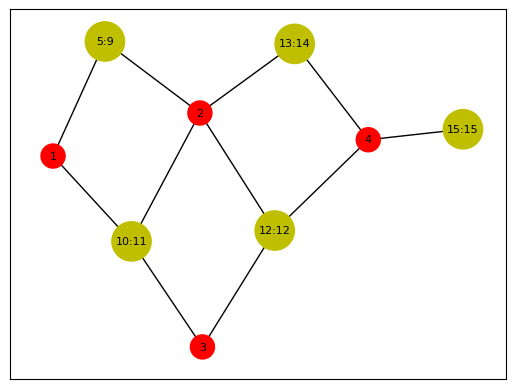

prune edges: [(1, 8), (5, 15), (6, 14), (11, 15)]
'/mnt/michael/gitrepos/bb-sbbu/data/nmr_rand/test34_chain_A_dmax_5.nmr'


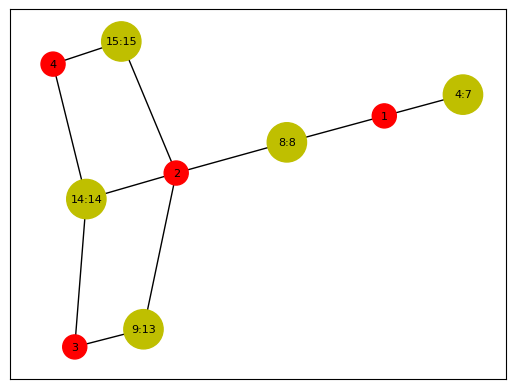

prune edges: [(4, 9), (6, 15), (7, 14), (11, 15)]
'/mnt/michael/gitrepos/bb-sbbu/data/nmr_rand/test700_chain_A_dmax_5.nmr'


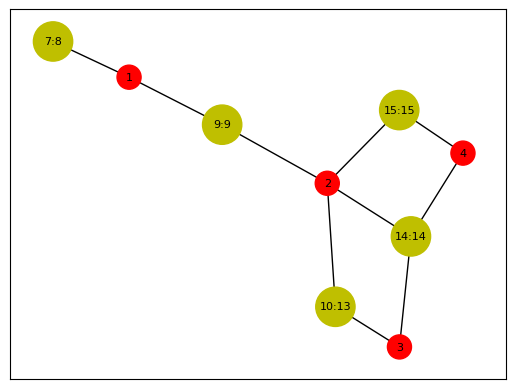

prune edges: [(2, 7), (4, 12), (6, 13), (10, 14)]
'/mnt/michael/gitrepos/bb-sbbu/data/nmr_rand/test794_chain_A_dmax_5.nmr'


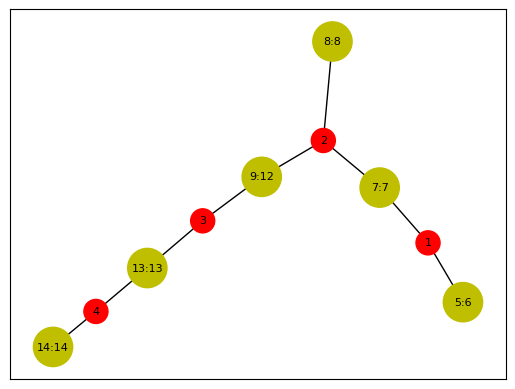

In [12]:
def plot_graph(G, fnmr, savefig=False):
    print("'" + fnmr + "'")
    pos = nx.spring_layout(G)    
    node_color = ['y' if ':' in node else 'r' for node in G.nodes()]
    node_size = [800 if ':' in node else 300 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
        node_size=node_size, 
        node_shape='o', 
        node_color=node_color)
    nx.draw_networkx_labels(G, pos, font_color='k', font_size=8)
    nx.draw_networkx_edges(G, pos)
    if savefig:
        plt.savefig(fnmr.replace('.nmr', '.pdf'), format='pdf')
    plt.show()

# plot graphs
PDB = set(df['PDB'])
for fn in sorted(os.listdir(nmr_folder)):
    if not fn.endswith('.nmr'):
        continue
    pdb = fn.split('_')[0]
    if pdb not in PDB:
        continue
    fn = os.path.join(nmr_folder, fn)
    fn = os.path.abspath(fn)
    nmr = NMR(fn)
    E, S = nmr.E, nmr.S # edges and segments
    G = nmr.ordering_graph # ordering graph
    print('prune edges:', [(e.i, e.j) for e in nmr.pruneEdges])
    plot_graph(G, fn, True)

## Results: data/nmr

In [2]:
nmr_folder = 'data/nmr/'

# run read_results.py and create results.csv
os.system('python read_results.py -wdir ' + nmr_folder)

df = pd.read_csv(os.path.join(nmr_folder, 'results.csv'))

# extract DMAX and PDB ID from fnmr
df['PDB'] = df['fnmr'].apply(lambda x: x.split('/')[-1].split('_')[0].replace('.nmr', ''))
df['DMAX'] = df['fnmr'].apply(lambda x: x.split('_')[-1].replace('.nmr',''))

print('tmax: ', df['tmax'].unique())
print('DMAX: ', df['DMAX'].unique())
print('timeoutBB: ', df['timeoutBB'].unique())

print('All columns:')
for col in sorted(df.columns):
    print('  ', col)

# columns to keep
cols = [
    'PDB', 'DMAX', 
    '|V|', '|E|', '|S|',
    'costRX', 'costGD', 'costSB', 'costBB', 
    'timeGD', 'timeSB', 'timeBB',  'timeoutBB',
]
df = df[cols]

# sort by DMAX and nnodes
df = df.sort_values(by=['DMAX', '|V|'])

df.head()

Parameters:
   wdir = data/nmr/

Getting log files from wdir=data/nmr/
Saving results to data/nmr/results.csv
tmax:  [7200]
DMAX:  ['5' '4' '6' '7']
timeoutBB:  [ 0. nan  1.]
All columns:
   DMAX
   PDB
   clean_log
   costBB
   costGD
   costRX
   costSB
   dump
   fnmr
   solver
   timeBB
   timeGD
   timeSB
   timeoutBB
   tmax
   verbose
   |E|
   |S|
   |V|


,PDB,DMAX,|V|,|E|,|S|,costRX,costGD,costSB,costBB,timeGD,timeSB,timeBB,timeoutBB
3,1n6t,4,30,16,14,44.0,44.0,4.400000e+01,44.0,0.0,0.0,0.0,0.0
12,1fw5,4,60,48,39,104.0,104.0,1.040000e+02,104.0,0.0,0.0,0.0,0.0
9,1adx,4,120,36,50,1342.0,1081966.0,2.163816e+06,1081966.0,0.0,0.0,7201.0,1.0
41,1bdo,4,240,56,97,2824.0,604031750.0,1.000000e+09,604031750.0,0.0,0.0,7201.0,1.0
56,1all,4,480,284,269,864.0,1342.0,1.342000e+03,1342.0,0.0,0.0,7201.0,1.0


In [3]:
# plot [DMAX, PDB] vs [timeGD, timeSB, timeBB]
for dmax in df['DMAX'].unique():
    dfA = df[df['DMAX']==dmax].copy()
    # replace zero values by 1E-3
    dfA['timeGD'] = dfA['timeGD'].apply(lambda x: 1E-3 if x==0 else x)
    dfA['timeSB'] = dfA['timeSB'].apply(lambda x: 1E-3 if x==0 else x)
    dfA['timeBB'] = dfA['timeBB'].apply(lambda x: 1E-3 if x==0 else x)
    # sort by |V|
    dfA.sort_values(by=['|S|'], inplace=True)
    dfA.rename(columns={'timeGD':'GD', 'timeSB':'SB', 'timeBB':'BB'}, inplace=True)
    display(dfA[['PDB','|S|','GD','SB','BB']])
    fig = px.scatter(dfA, x='PDB', y=['GD','SB','BB'], title=f'Time per instance (DMAX={dmax})', log_y=True)    
    # use lines instead of markers
    fig.update_traces(mode='lines+markers')
    # add a line y=3600 for all x
    fig.add_trace(go.Scatter(x=dfA['PDB'], y=[3600]*len(dfA['PDB']), mode='lines', name='1h'))
    # change axis labels
    fig.update_xaxes(title_text='PDB (sorted by |S|)')
    fig.show()

,PDB,|S|,GD,SB,BB
3,1n6t,14,0.001,0.001,0.001
12,1fw5,39,0.001,0.001,0.001
9,1adx,50,0.001,0.001,7201.000
41,1bdo,97,0.001,0.001,7201.000
56,1all,269,0.001,0.001,7201.000
63,6s61,273,0.001,0.001,7201.000
7,4wua,538,NaN,NaN,NaN
57,1fhl,540,NaN,NaN,NaN
10,6czf,697,NaN,NaN,NaN
54,5ijn,917,NaN,NaN,NaN


,PDB,|S|,GD,SB,BB
40,1n6t,27,0.001,0.001,0.001
0,1fw5,57,0.001,0.001,0.001
2,1adx,117,0.001,0.001,0.001
43,1bdo,237,0.001,0.001,0.001
11,1all,477,0.001,0.001,0.001
29,6s61,513,0.001,0.001,0.001
52,1fhl,999,2.000,0.001,0.001
30,4wua,1027,2.000,0.001,0.001
58,6czf,1491,6.000,0.001,0.001
14,5ijn,1941,12.000,0.001,0.001


,PDB,|S|,GD,SB,BB
66,1n6t,27,0.001,0.001,0.001
51,1fw5,57,0.001,0.001,0.001
31,1adx,117,0.001,0.001,0.001
45,1bdo,237,1.000,0.001,0.001
16,1all,477,2.000,0.001,0.001
42,6s61,513,2.000,0.001,0.001
15,1fhl,999,21.000,0.001,0.001
46,4wua,1028,12.000,0.001,0.001
20,6czf,1491,27.000,0.001,0.001
18,5ijn,1944,59.000,0.001,0.001


,PDB,|S|,GD,SB,BB
17,1n6t,27,0.001,0.001,0.001
49,1fw5,57,0.001,0.001,0.001
38,1adx,117,0.001,0.001,0.001
25,1bdo,237,3.000,0.001,0.001
65,1all,477,4.000,0.001,0.001
37,6s61,513,5.000,0.001,0.001
8,1fhl,999,53.000,0.001,0.001
13,4wua,1029,19.000,0.001,0.001
28,6czf,1491,72.000,0.001,0.001
61,5ijn,1945,170.000,0.001,0.001


In [4]:
dfA = df[['PDB','DMAX']].groupby(['PDB']).count().reset_index()
dfA_min = dfA['DMAX'].min()
dfA_max = dfA['DMAX'].max()
DMAX = df['DMAX'].unique()
print('Global Parameters:')
print(f'   - Number of PDB: {len(dfA)}')
print(f'   - DMAX: {df["DMAX"].unique()}')
print(f'   - (Min, Max) numbers of rows per PDB: {dfA_min, dfA_max}')

Global Parameters:
   - Number of PDB: 17
   - DMAX: ['4' '5' '6' '7']
   - (Min, Max) numbers of rows per PDB: (4, 4)


In [5]:
# Group by DMAX
dfA = df.copy()
df_DMAX = {}
for k, dmax in enumerate(DMAX):
    dfB = dfA[dfA['DMAX'] == dmax].copy()
    df_DMAX[dmax] = dfB
    # remove unwanted columns
    if k > 0:
        df_DMAX[dmax].drop(columns=['|V|'], inplace=True)
    df_DMAX[dmax].drop(columns=['DMAX'], inplace=True)
    # rename columns
    cols = {col:f'{col}_{dmax}' for col in dfB.columns if col not in ['PDB','|V|']}
    for col, colname in cols.items():
        if '|_' in colname:
            cols[col] = f'{col[:-1]}_{dmax}|'
    df_DMAX[dmax].rename(columns=cols, inplace=True)
# merge all dataframes
dfB = df_DMAX[min(df_DMAX)]
for dmax in df_DMAX:
    if dmax == min(df_DMAX):
        continue
    dfB = pd.merge(dfB, df_DMAX[dmax], on=['PDB'])
df_DMAX = dfB
# change columns order
cols = list(dfB.columns)

# display
df_DMAX.columns

Index(['PDB', '|V|', '|E_4|', '|S_4|', 'costRX_4', 'costGD_4', 'costSB_4',
       'costBB_4', 'timeGD_4', 'timeSB_4', 'timeBB_4', 'timeoutBB_4', '|E_5|',
       '|S_5|', 'costRX_5', 'costGD_5', 'costSB_5', 'costBB_5', 'timeGD_5',
       'timeSB_5', 'timeBB_5', 'timeoutBB_5', '|E_6|', '|S_6|', 'costRX_6',
       'costGD_6', 'costSB_6', 'costBB_6', 'timeGD_6', 'timeSB_6', 'timeBB_6',
       'timeoutBB_6', '|E_7|', '|S_7|', 'costRX_7', 'costGD_7', 'costSB_7',
       'costBB_7', 'timeGD_7', 'timeSB_7', 'timeBB_7', 'timeoutBB_7'],
      dtype='object')

In [8]:
# table of number of vertices, edges and segments for each PDB
cols = ['PDB', '|V|']
cols += sorted([c for c in df_DMAX.columns if ('|' in c) and ('_') in c])
df_DMAX[cols]

# export to latex
fn = '/mnt/michael/gitrepos/bb-sbbu/latex/data/nmr/cost_all.tex'
print(f'Exporting to {fn}')
df_DMAX[cols].to_latex(fn, index=False)

Exporting to /mnt/michael/gitrepos/bb-sbbu/latex/data/nmr/cost_all.tex


In [ ]:
# table of cost for each instance and each algorithm
for dmax in DMAX:
    cols = ['PDB'] + sorted([c for c in df_DMAX.columns if ('cost' in c) and (f'_{dmax}' in c)])    
    dfA = df_DMAX[cols].copy()
    dfA.rename(columns={col:col.split('_')[0].replace('cost','') for col in dfA.columns}, inplace=True)
    cols = ['PDB', 'RX', 'GD', 'SB']
    cols += [c for c in dfA.columns if c not in cols]
    dfA = dfA[cols]    
    dfA['timeoutBB'] = df_DMAX[f'timeoutBB_{dmax}'].astype(bool)
    # replace numbers smaller than zero by nan
    dfA[cols[2:]] = dfA[cols[2:]].applymap(lambda x: np.nan if x < 0 else x)    
    print(f'Cost for DMAX={dmax}')
    # set display options for float precision, only for dfA
    pd.set_option('display.float_format', lambda x: '%.3g' % x)
    # scaling by min cost
    dfA['cost_min'] = dfA[cols[2:]].min(axis=1)
    dfA[['RX','GD','SB','BB']] = dfA[['RX','GD','SB','BB']].div(dfA['cost_min'], axis=0)    
    display(dfA)
    # save to latex
    dfA.to_latex(f'latex/data/nmr/cost_{dmax}.tex', index=False)

Cost for DMAX=4


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,44
1,1fw5,1,1,1,1,False,104
2,1adx,0.00124,1,2,1,True,1.08e+06
3,1bdo,4.68e-06,1,1.66,1,True,6.04e+08
4,1all,0.644,1,1,1,True,1.34e+03
5,6s61,0.998,1,1,1,True,854
6,1fhl,NaN,NaN,NaN,NaN,True,NaN
7,4wua,NaN,NaN,NaN,NaN,True,NaN
8,6czf,NaN,NaN,NaN,NaN,True,NaN
9,5ijn,NaN,NaN,NaN,NaN,True,NaN


Cost for DMAX=5


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,54
1,1fw5,1,1,1,1,False,114
2,1adx,1,1,1,1,False,234
3,1bdo,1,1,1,1,False,474
4,1all,1,1,1,1,False,954
5,6s61,1,1,1,1,False,1.03e+03
6,1fhl,1,1,1,1,False,2e+03
7,4wua,1,1,1,1,False,2.06e+03
8,6czf,1,1,1,1,False,2.98e+03
9,5ijn,1,1,1,1,False,3.9e+03


Cost for DMAX=6


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,54
1,1fw5,1,1,1,1,False,114
2,1adx,1,1,1,1,False,234
3,1bdo,1,1,1,1,False,474
4,1all,1,1,1,1,False,954
5,6s61,1,1,1,1,False,1.03e+03
6,1fhl,1,1,1,1,False,2e+03
7,4wua,1,1,1,1,False,2.06e+03
8,6czf,1,1,1,1,False,2.98e+03
9,5ijn,1,1,1,1,False,3.9e+03


Cost for DMAX=7


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,54
1,1fw5,1,1,1,1,False,114
2,1adx,1,1,1,1,False,234
3,1bdo,1,1,1,1,False,474
4,1all,1,1,1,1,False,954
5,6s61,1,1,1,1,False,1.03e+03
6,1fhl,1,1,1,1,False,2e+03
7,4wua,1,1,1,1,False,2.06e+03
8,6czf,1,1,1,1,False,2.98e+03
9,5ijn,1,1,1,1,False,3.9e+03
